In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/cleaned_reviews.csv")
df.head()

,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,...,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity,cleaned_review,sentiment_score,sentiment
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,...,1.0,1.0,no,NaN,NaN,NaN,NaN,hour takeoff received mail stating cryptic mes...,-0.8704,Negative
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,...,1.0,2.0,no,A320,1.0,2.0,2.0,recently delay british airway bru lhr due staf...,-0.7635,Negative
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,...,4.0,3.0,yes,A320,4.0,NaN,NaN,boarded time took age get runway due congestio...,0.4404,Positive
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,...,1.0,1.0,no,NaN,NaN,NaN,NaN,day flight advised ba cancelled asked u rebook...,-0.0508,Negative
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,...,1.0,1.0,no,NaN,1.0,1.0,1.0,traveled lisbon dream vacation cruise portugal...,0.8901,Positive


In [2]:
df["OverallRating"].describe()


count    3696.000000
mean        4.734307
std         3.175306
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        10.000000
Name: OverallRating, dtype: float64

### FEATURE ENGINEERING

In [3]:
features = df[
    [
        "sentiment_score",
        "GroundService",
        "Food&Beverages",
        "ValueForMoney"
    ]
].copy()


In [4]:
for col in features.columns:
    features[col] = pd.to_numeric(features[col], errors="coerce")


### TRAIN–TEST SPLIT

In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
features_imputed = imputer.fit_transform(features)


In [6]:
target = df["OverallRating"]


### MODEL TRAINING

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features_imputed,
    target,
    test_size=0.2,
    random_state=42
)


In [8]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Remove rows where y_train has NaN
mask = ~y_train.isna()
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

lr = LinearRegression()
lr.fit(X_train_clean, y_train_clean)

lr_pred = lr.predict(X_test)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_clean, y_train_clean)
rf_pred = rf.predict(X_test)


### MODEL EVALUATION

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

# Remove rows where y_test has NaN
mask_test = ~y_test.isna()
y_test_clean = y_test[mask_test]
rf_pred_clean = rf_pred[mask_test]

print("Random Forest")
print("MAE:", mean_absolute_error(y_test_clean, rf_pred_clean))
print("R2 :", r2_score(y_test_clean, rf_pred_clean))


Random Forest
MAE: 0.9867890575779436
R2 : 0.8185176335682283


In [11]:
import joblib
joblib.dump(rf, "../models/csat_model.pkl")


['../models/csat_model.pkl']

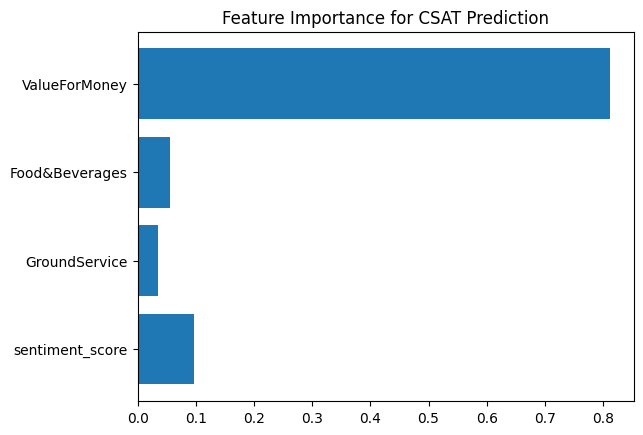

In [12]:
import matplotlib.pyplot as plt

importance = rf.feature_importances_
plt.barh(features.columns, importance)
plt.title("Feature Importance for CSAT Prediction")
plt.show()
